# Customer Churn Prediction 

## Introduction
**Customer churn occurs when customers or subscribers stop doinng business** with a company or service. This is also called customer attrition or customer defection. Many service providers such as telephone companies, internet or insurance firms, banks often use customer churn analysis as one of the key business metrics because cost of retaining an existing customer is far less than acquring new ones. 
 
## About the data
1. Target variable is called *Churn* - it represents customers who left within the last month.
2. Demographic information of customers is captured in *gender*, *age*, *partners* and *dependents* variables.
3. Customer account inforation is present in *contract*, *payment method*, *Monthly charges*, *total charges* and *tenure*
4. Services opted by customers are in *Phone service*, *Multiple lines*, *Online backup*, *Tech support*, *Streaming Movies/TV*

## Objective 
This the demonstration in R to analyze all relevant customer data and predict Customer churn.  

## Load libraries and functions
Load packages like *tidyverse*, *purrr*, *gridExtra*, *caret* and functions.

In [ ]:
library("readr")
library("dplyr")
library("tidyr")
library("purrr")
library("corrplot")
library("stringr")
library("ROCR")
library("ggplot2")
library("gridExtra")
library("caret")
library("kableExtra")

# This function calculates the confusion matrix
cm <- function(model, data, target){
confusionMatrix(predict(model, newdata = data), target)
}

# This function identifies and plots the best probability cutoff values by maximizing tpr and fpr values from the ROC plot 
roc_cutoff <- function(model, data, target) {
# Check for the stack models  
if(str_detect(deparse(substitute(model)),'stack')) {
pred <- predict(model, data, type = "prob") %>% data.frame(No = ., Yes = 1 -.)
pred <- pred[,1]
}
else{
pred <- predict(model, data, type = 'prob')[,2]
}
# ROCR considers the later level to be the positive class. 
pred <- prediction(pred, target, label.ordering = c("No","Yes"))
eval <- performance(pred, "tpr","fpr")
plot(eval)

# maximize the TPR and FPR
max <- which.max(slot(eval,"y.values")[[1]] +  1 - slot(eval,"x.values")[[1]])
# get the best cutoff value
cutoff <- slot(eval, "alpha.values")[[1]][max]
tpr <- slot(eval, "y.values")[[1]][max]
fpr <- slot(eval, "x.values")[[1]][max]
abline(h = tpr, v = fpr, lty = 2, col = "blue") # best cutoff
text(0.7,0.2, paste0("At best cutoff = ", round(cutoff,2)), col = "blue")
# Default cutoff
default <- last(which(slot(eval, "alpha.values")[[1]] >= 0.5))
defaulty <- slot(eval,"y.values")[[1]][default]
defaultx <- slot(eval,"x.values")[[1]][default]
abline(h = defaulty, v = defaultx, col = "red", lty = 2) # Default cutoff
text(0.7,0.3, paste0("At default cutoff = ", 0.50), col = "red")
return(cutoff)
}

# Find the missing values in the columns of the dataframe
missing_values <- function(df){
  
missing <- df %>% gather(key = "key", value = "value") %>% mutate(is.missing = is.na(value)) %>% 
  group_by(key) %>% mutate(total = n()) %>% 
  group_by(key, total, is.missing) %>%
    summarise(num.missing = n()) %>% 
    mutate(perc.missing = num.missing/total * 100) %>% ungroup()
  
  return(missing)
}

# Plot add on services
plot_addon_services <- function(df,group_var){
  # Filter customers who have internet at home
  withInternet <- df %>% filter(InternetService %ni% c("No"))
  # Group by Churn and add on service var and calculate the Percentage of customers
  withInternet %>% group_by(Churn, !! sym(group_var)) %>% tally(name = "count") %>% 
    mutate(Percent = count /nrow(withInternet)) %>%
    mutate(Percent = round(Percent,2)) %>%
    # Plot the percentage and Churn behaviour of each group
    ggplot(aes(x = !! sym(group_var), y = Percent, fill = Churn)) + geom_bar(stat = "identity") + 
    geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + 
    theme_minimal() + scale_fill_brewer(palette="Dark2") + 
    scale_y_continuous(labels = scales::percent_format(accuracy = 1)) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
}

'%ni%' <- Negate('%in%')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


corrplot 0.84 loaded

Loading required package: gplots


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




# Data preprocessing and cleaning

The data was downloaded from [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn). The data contains **7043 rows** and **21 columns** (variables) including the binary target variable called *Churn*.

In [ ]:
churn <- read_csv("..//input//telco-customer-churn//WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(churn)

Parsed with column specification:
cols(
  .default = col_character(),
  SeniorCitizen = col_double(),
  tenure = col_double(),
  MonthlyCharges = col_double(),
  TotalCharges = col_double()
)

See spec(...) for full column specifications.



# A tibble: 7,043 x 21
   customerID gender SeniorCitizen Partner Dependents tenure PhoneService
   <chr>      <chr>          <dbl> <chr>   <chr>       <dbl> <chr>       
 1 7590-VHVEG Female             0 Yes     No              1 No          
 2 5575-GNVDE Male               0 No      No             34 Yes         
 3 3668-QPYBK Male               0 No      No              2 Yes         
 4 7795-CFOCW Male               0 No      No             45 No          
 5 9237-HQITU Female             0 No      No              2 Yes         
 6 9305-CDSKC Female             0 No      No              8 Yes         
 7 1452-KIOVK Male               0 No      Yes            22 Yes         
 8 6713-OKOMC Female             0 No      No             10 No          
 9 7892-POOKP Female             0 Yes     No             28 Yes         
10 6388-TABGU Male               0 No      Yes            62 Yes         
# … with 7,033 more rows, and 14 more variables: MultipleLines <chr>,
#   InternetService

1. Replace *"No internet service"* to *"No"*.
2. Remove *"(automatic)"* from PaymentMethod column.
3. Recode *SeniorCitizen* column to factor. Make "1" = "Yes" and "0" = "No"
4. Recode *tenure* column to categorical column.
5. Remove customerID column from the dataset.
6. Convert *character* columns to *factor* columns.

In [ ]:
# Map "No internet service to No"

recode <- c("OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "MultipleLines")

churn <- as.data.frame(churn)

for (col in recode) {
  churn[,col] <- as.character(churn[,col])
  temp <- if_else(churn[,col] %in% c("No internet service","No phone service"), "No",churn[,col])
churn[,col] <- as.factor(temp)
}

# Remove (automatic) from PaymentMethod
churn$PaymentMethod <- str_remove(churn$PaymentMethod, "\\(automatic\\)") %>% str_trim(., side = "right") %>% as.factor()

# Does not make sense to have senior citizen as numbers. 
churn$SeniorCitizen <- as.factor(recode(churn$SeniorCitizen, "1" = "Yes", "0" = "No"))

# Make tenure as categorical variable for easier ploting 
churn <- churn %>% mutate(tenure_group = case_when(tenure <= 12 ~ "0-12M",
                                           tenure >12 & tenure <=24 ~ "12-24M",
                                           tenure > 24 & tenure <= 48 ~ "24-48M",
                                           tenure > 48 & tenure <= 60 ~ "48-60M",
                                           tenure >60 ~ ">60M"
                ))
churn$tenure_group <- as.factor(churn$tenure_group)

# Remove columns not needed

churn <- churn %>% select(-one_of(c("customerID")))

# Turn character columns to factor
recode <- churn %>% select_if(is.character) %>% colnames()

for(col in recode){
  churn[,col] <-  as.factor(churn[,col])

}

## Look at the unique values after cleaning 

churn[-1] %>% select_if(is.factor) %>% map(function(x) unique(x))

$SeniorCitizen
[1] No  Yes
Levels: No Yes

$Partner
[1] Yes No 
Levels: No Yes

$Dependents
[1] No  Yes
Levels: No Yes

$PhoneService
[1] No  Yes
Levels: No Yes

$MultipleLines
[1] No  Yes
Levels: No Yes

$InternetService
[1] DSL         Fiber optic No         
Levels: DSL Fiber optic No

$OnlineSecurity
[1] No  Yes
Levels: No Yes

$OnlineBackup
[1] Yes No 
Levels: No Yes

$DeviceProtection
[1] No  Yes
Levels: No Yes

$TechSupport
[1] No  Yes
Levels: No Yes

$StreamingTV
[1] No  Yes
Levels: No Yes

$StreamingMovies
[1] No  Yes
Levels: No Yes

$Contract
[1] Month-to-month One year       Two year      
Levels: Month-to-month One year Two year

$PaperlessBilling
[1] Yes No 
Levels: No Yes

$PaymentMethod
[1] Electronic check Mailed check     Bank transfer    Credit card     
Levels: Bank transfer Credit card Electronic check Mailed check

$Churn
[1] No  Yes
Levels: No Yes

$tenure_group
[1] 0-12M  24-48M 12-24M >60M   48-60M
Levels: >60M 0-12M 12-24M 24-48M 48-60M

## Missing values

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


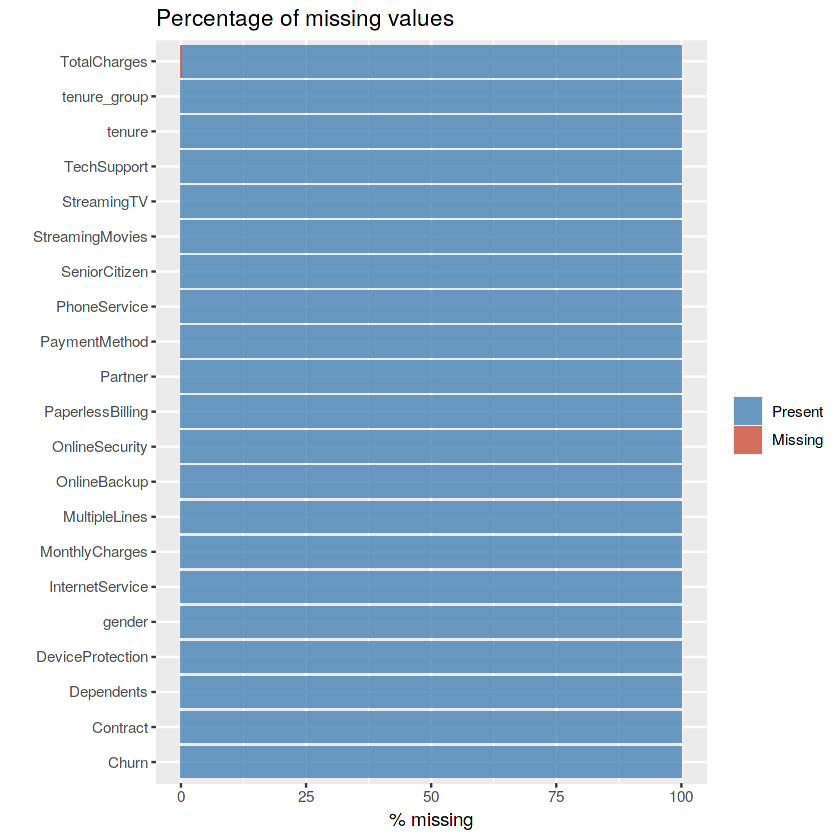

In [ ]:
# Call missing_values function 
missing <- missing_values(churn)

p1 <- ggplot(missing) + geom_bar(aes( x= reorder(key, desc(perc.missing)), y = perc.missing, fill = is.missing), stat = 'identity', alpha = 0.8) + scale_fill_manual(name = "", values = c('steelblue','tomato3'), label = c("Present", "Missing")) + coord_flip() + labs(title = "Percentage of missing values",x = '',y = '% missing')

# Plot missing values
p1

# remove rows with missing values
churn <- na.omit(churn)

# Exploratory data analysis

In [ ]:
print("Percentage of customers churn")
prop.table(table(churn$Churn))

[1] "Percentage of customers churn"



      No      Yes 
0.734215 0.265785 

From the table above we notice that 73.4% of the customers did not churn. This can server as our baseline model *i.e.* if we predict every customer to not churn we will be right on average 73.4% of the times. Let us explore the data further. 

## Correlation plot between numeric variables

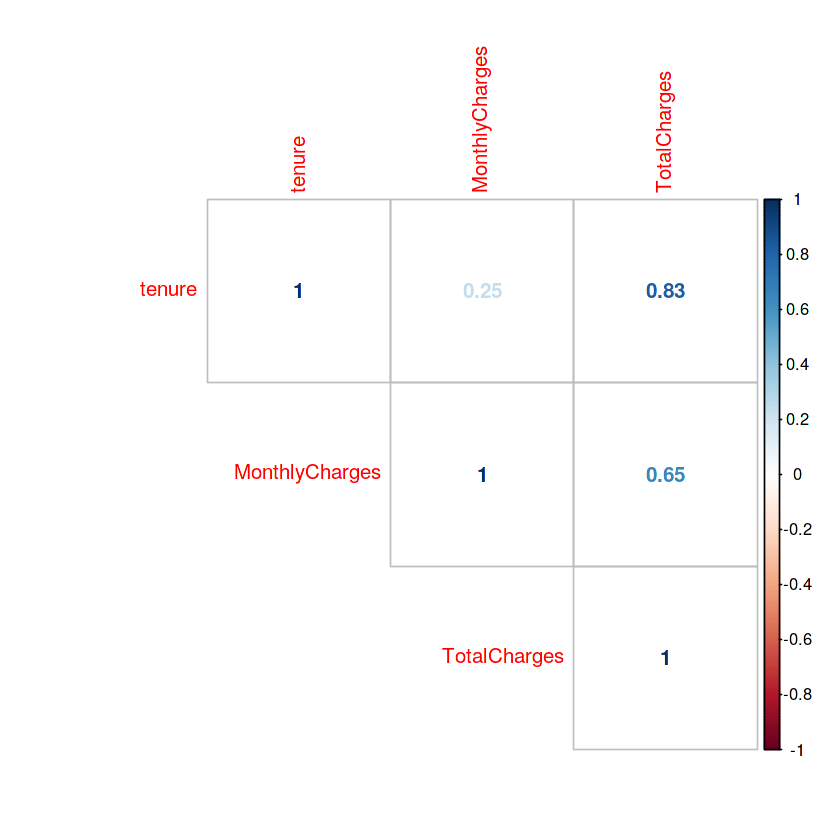

In [ ]:
# Correlation matrix of numeric variables
cor_matrix<- churn %>% select_if(is.numeric) %>% cor()

corrplot(cor_matrix,method = "number", type = "upper")

# Plots of categorical variables

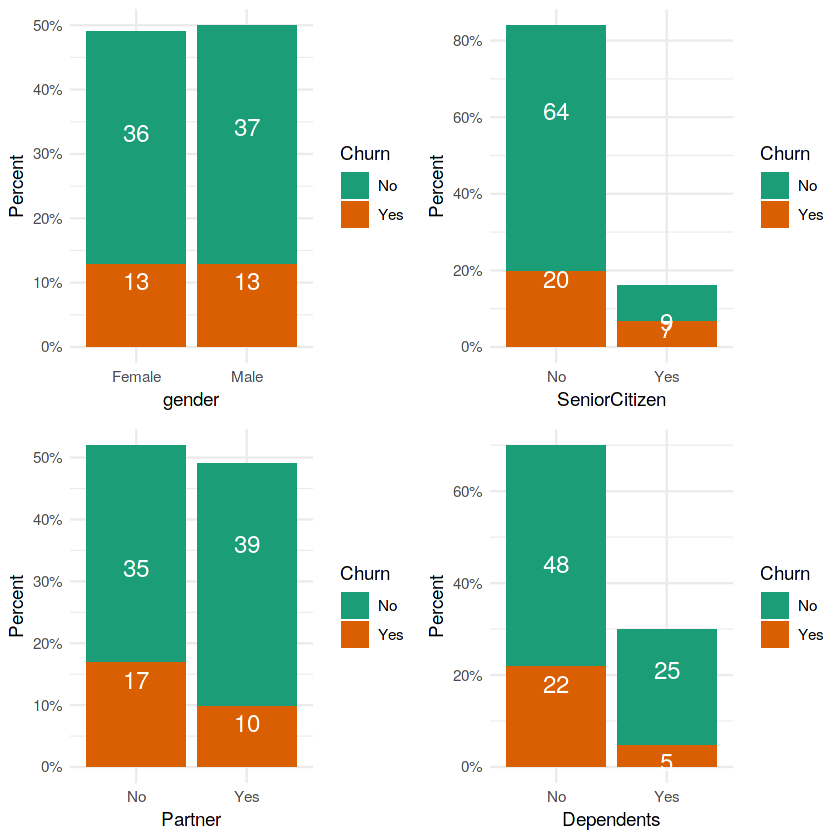

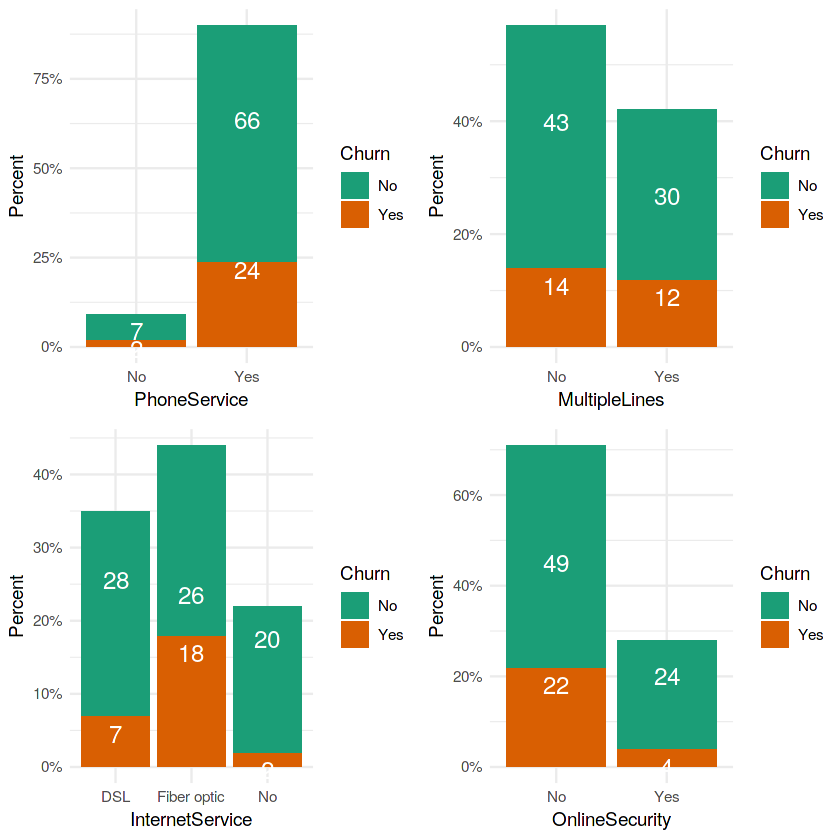

In [ ]:
p1 <- churn %>% group_by(gender, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = gender, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p2 <- churn %>% group_by(SeniorCitizen, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = SeniorCitizen, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.0, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p3 <- churn %>% group_by(Partner, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = Partner, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p4 <- churn %>% group_by(Dependents, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = Dependents, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p5 <- churn %>% group_by(PhoneService, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = PhoneService, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.0, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p6 <- churn %>% group_by(MultipleLines, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = MultipleLines, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p7 <- churn %>% group_by(InternetService, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = InternetService, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p8 <- churn %>% group_by(OnlineSecurity, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = OnlineSecurity, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

grid.arrange(p1, p2, p3, p4, ncol=2)
grid.arrange(p5, p6, p7, p8, ncol = 2)

1. **Does gender makes a differnce?** Does not seem to play any significant role in predicting customer churn.

2. **How does Senior Citizen behave?** Almost 50% of the total Senior citizens population churn. Company to could come up with offers specifically catering for senior citizen demands.

3. **Does having a partner makes a differnece?** It seems like customers without a partner are more likely to churn than with customers with the partner.

4. **Effect of dependents?** Customers with dependents are more likely to stay than without. However, customers with dependents are only 30% of the total customer population.

5. **Phone service** Customers without phone phone service are less likely to churn however, they form only 9% of the total customers

6. **Multiple lines** I don't know what multiple lines mean. However, it seems that customers with multiple lines are more likely to churn. 

7. **Cutomers with Internet services** It is very interesting to see that of all the customers the customers with Fiber optic internet service at home are highly prone to churning. 

8. **Customers with Online security** Customers with online security are more likely to churn.

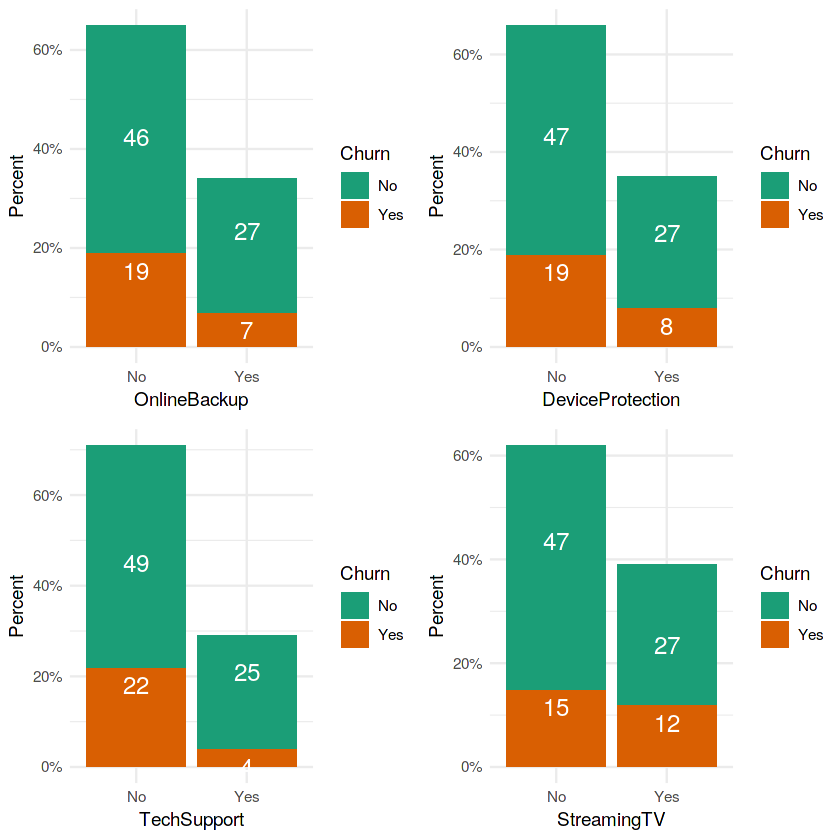

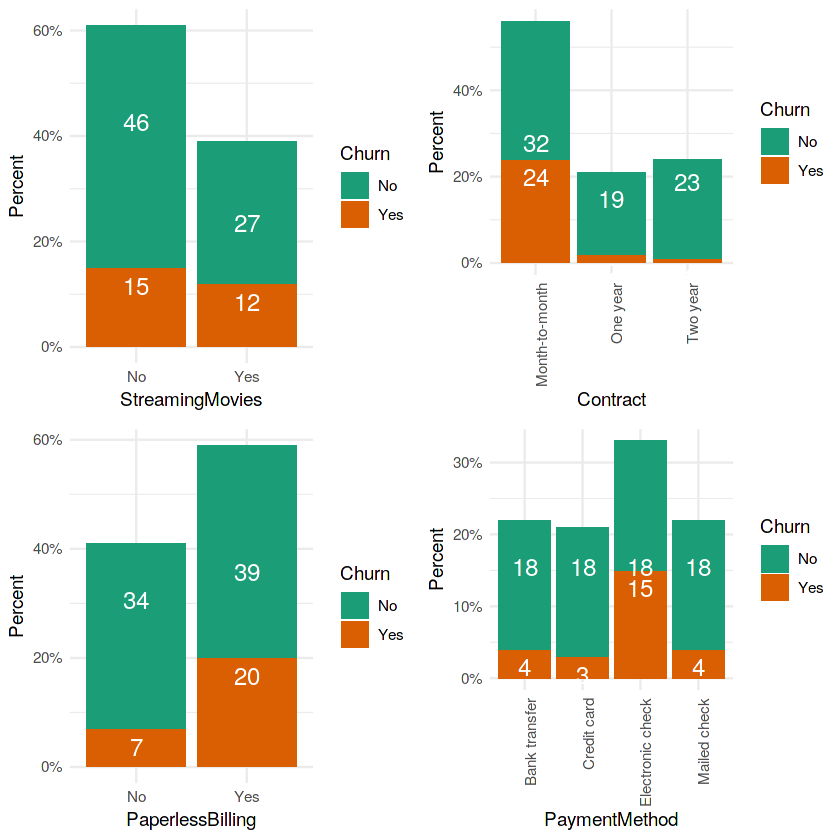

In [ ]:
p1 <- churn %>% group_by(OnlineBackup, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = OnlineBackup, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))


p2 <- churn %>% group_by(DeviceProtection, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = DeviceProtection, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p3 <- churn %>% group_by(TechSupport, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = TechSupport, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p4 <- churn %>% group_by(StreamingTV, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = StreamingTV, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p5 <- churn %>% group_by(StreamingMovies, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = StreamingMovies, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p6 <- churn %>% group_by(Contract, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = Contract, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1)) + theme(axis.text.x = element_text(angle = 90, hjust = 1))

p7 <- churn %>% group_by(PaperlessBilling, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = PaperlessBilling, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p8 <- churn %>% group_by(PaymentMethod, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = PaymentMethod, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1)) + theme(axis.text.x = element_text(angle = 90, hjust = 1))

grid.arrange(p1, p2, p3, p4, ncol=2)
grid.arrange(p5, p6, p7, p8, ncol = 2)

What is the effect of internet addons on customer churning? Let us explore.
1. **Online backup and Device Protection service:** Customers with online backup and device propection service are less likely to churn. They like these add ons. 

2. **Technical support** Customers who opt for technical support are less likely to churn. Although less customers opt for technical support service however if they do they seem to stay the company.

3. **Does Streaming services help retain customers?** It does not look like that customers who opt for streaming services are more likely to stay infact it they are more prone to churning.

4. **What about Contract period?** Very interesting pattern. If the company is able to engage customers in 1 year or more contract customers are almost certain to stay.

5. **Paperless billing**. It is interesting to see that customers who opt for paperless billing service are more likely to churn. It may be due to the fact that people tend to forget paying bills if bill is hiding somewhere in their email or sms therefore, end up paying more which make them unhappy with company and they churn.

6. **Payment method** Very interesting pattern. Of all the customers paying bills through electronic check almost half of the customers churn. It may be due to the bad experience like bouncing of checks or some error on the company's part in processing check payments. 

## Some other interesting plots
Let us take a deeper look at the popularity of add on services such as *Tech Support*, *Streaming Movies*, *Online backup* etc. for the customers who have internet at home. For this we will filter out customers who have internet at home.

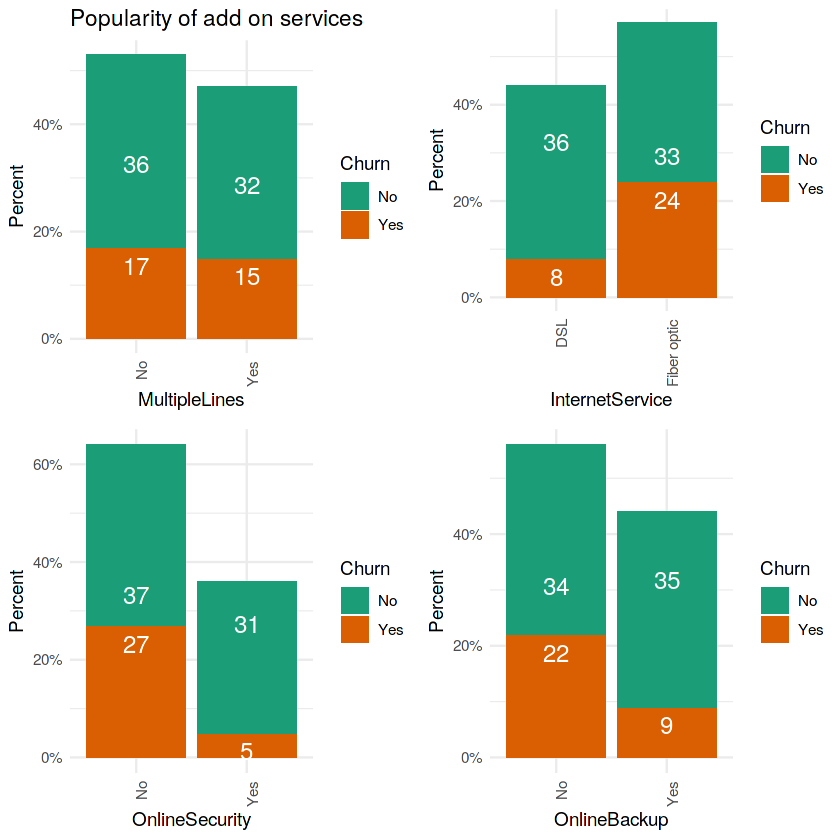

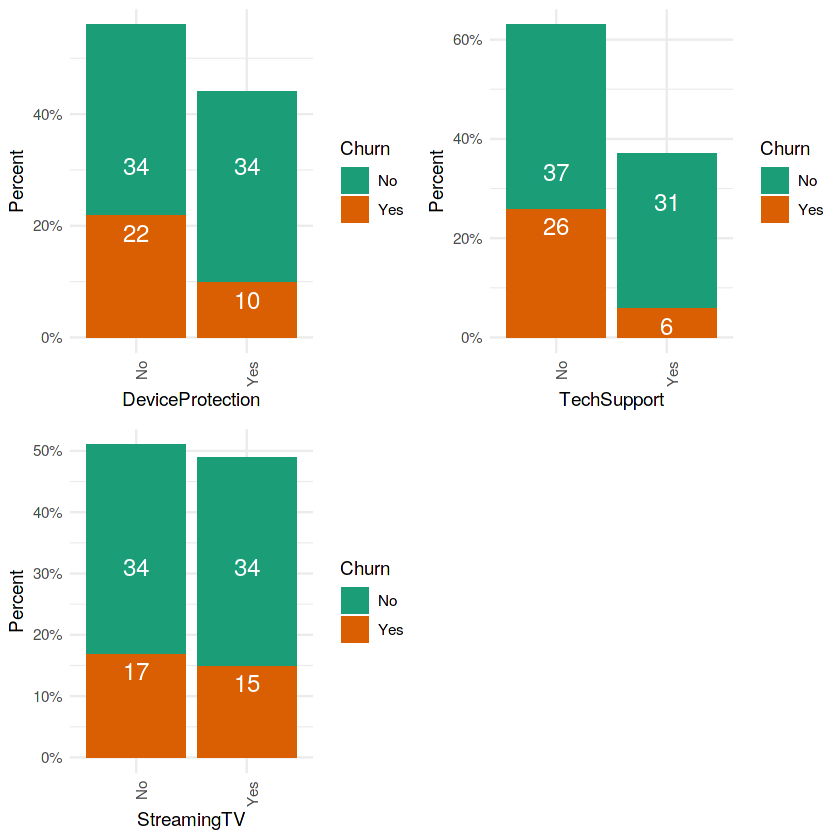

In [ ]:
# Create an adds on vector
adds_on <- names(churn)[7:13]

addson_plots <- map(adds_on, plot_addon_services, df = churn)

p1 <- addson_plots[[1]] + ggtitle("Popularity of add on services")
p2 <- addson_plots[[2]]
p3 <- addson_plots[[3]]
p4 <- addson_plots[[4]]
p5 <- addson_plots[[5]]
p6 <- addson_plots[[6]]
p7 <- addson_plots[[7]]

grid.arrange(p1, p2, p3, p4, ncol=2)
grid.arrange(p5, p6, p7, ncol = 2)

1. **Internet service:** Customers with Fiber optic service are more prone to churning than DSL service. It may be because DSL service may not be fast enough and customers use telco's internet and therefore less likely to churn.

2. **Online security & Online backup:** Customers who do not have Online security or backup service are more likely to churn.

3. **Device Protection and Tech Support:** Similarly customers who do not opt for device protection and tech support are more likely to churn.

4. **Streaming services:** Streaming services do not significantly make a difference in customer churn behavour.

Additionally, we also see that popularity of services is in the order StreamingMovies > StreamingTV > OnlineBackup > Device Protection > Tech support > Online security.

## Monthly charges paid by customers

Lets look at how much on average monthly charges are paid by customers who churn. My guess is customers who churn are paying higher monthly charges than customers who do not churn.

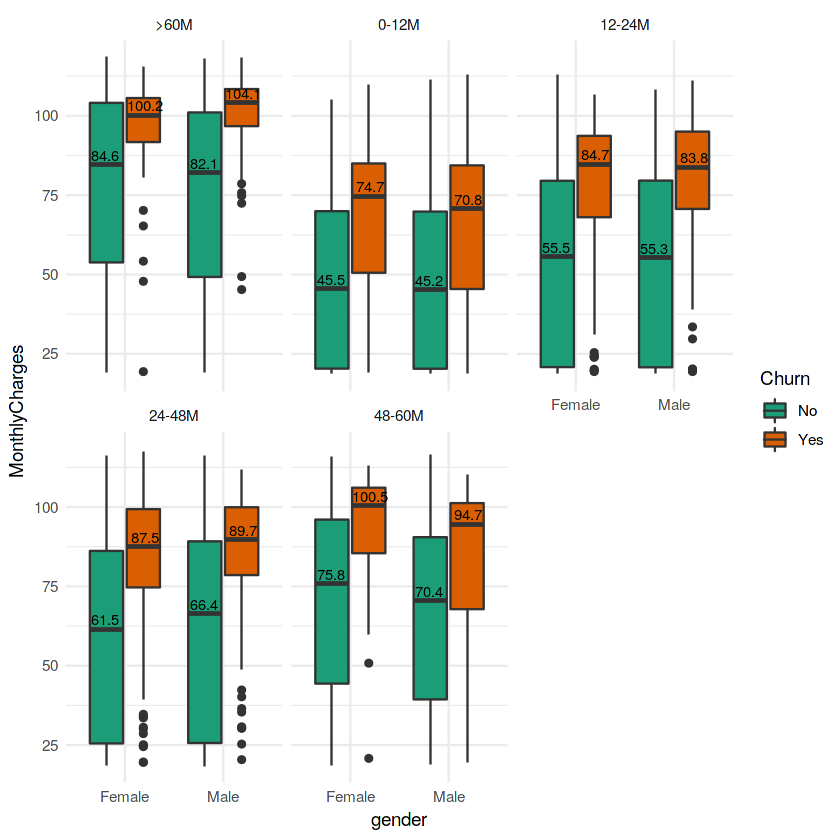

In [ ]:
df <- churn %>% group_by(gender, tenure_group, Churn) %>% 
   summarise(mean = median(MonthlyCharges)) %>% arrange(tenure_group)
# Define the x positions for plotting text
df$x <- rep(c(0.8,1.2,1.8,2.2),5)

churn %>% ggplot(aes(y = MonthlyCharges,  x= gender, fill = Churn)) + 
    geom_boxplot() + facet_wrap(~tenure_group) + 
  geom_text(data = df, aes(label = round(mean, 1), y = mean + 3.0, x = x), size = 3) + 
  theme_minimal() + scale_fill_brewer(palette="Dark2")

1. **Customers who churn pay much higher monthly bills** which makes sense since higher monthly bills would be hard on their pocket. It also seems to be a very distinguishing feature of people who churn.

2. Another interseting pattern which we can see from the plot above is that **as months pass by customers are happy to pay more**. The median monthly bills rise in the order 45,55,61,70,84 for tenures 0-12M, 12-24M, 24-48M, 48-60M and >60M, respectively.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



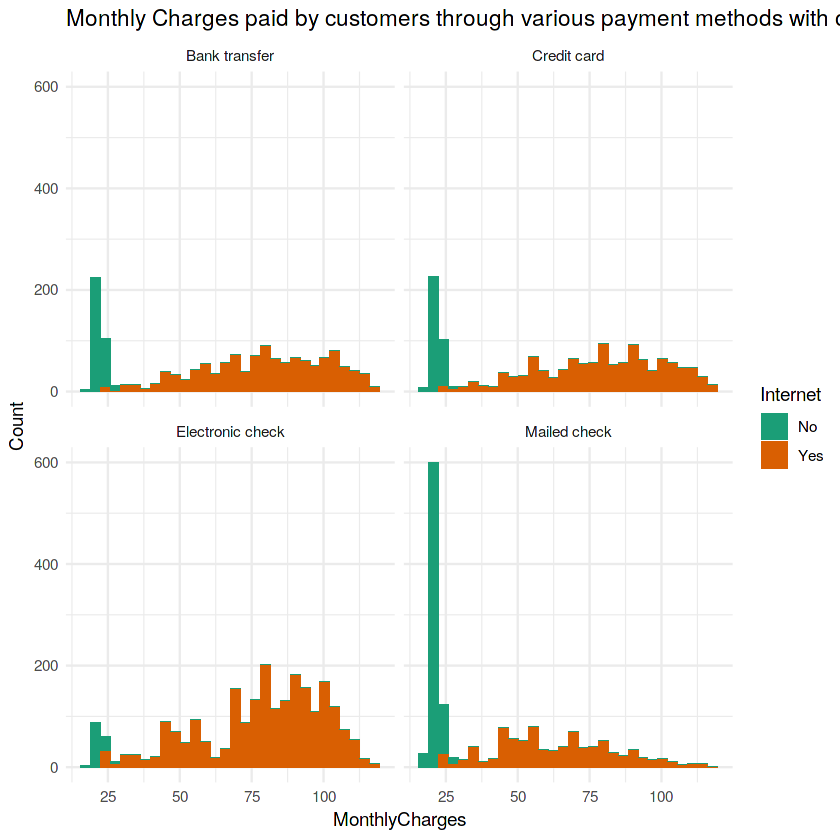

In [ ]:
churn$Internet <- ifelse(churn$InternetService %in% c("No"), "No", "Yes")

churn %>% ggplot(aes(x = MonthlyCharges, fill = Internet)) + 
    facet_wrap(~PaymentMethod) + theme_minimal() + 
    scale_fill_brewer(palette="Dark2") + 
    ggtitle(label = "Monthly Charges paid by customers through various payment methods with or without internet") +
    ylab(label = "Count") + geom_histogram()

From the plot above we can see that **majority of customers who do not have internet service at home prefer to pay bills by Mailed check** (which is expected). Additinally, such customers usually have small amount to be paid.

Also we can note that **most common payment method of customers who have internet service at home is Electronic check** although, *Bank tranfer and Credit card* are also popular means of payment.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



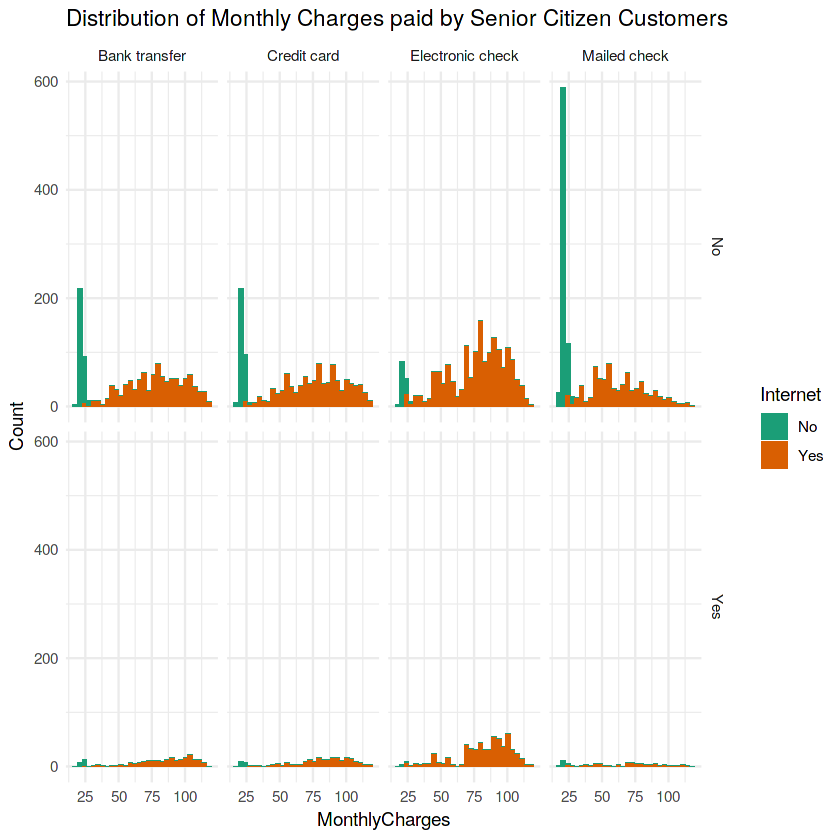

In [ ]:
  churn %>% ggplot(aes(x = MonthlyCharges, fill = Internet)) + 
    geom_histogram() + facet_grid(SeniorCitizen~PaymentMethod) + theme_minimal() + 
    scale_fill_brewer(palette="Dark2") + 
    ggtitle(label = "Distribution of Monthly Charges paid by Senior Citizen Customers") +
    ylab(label = "Count")

It looks like that overall **Mailed checks again are most common type of payment method for paying small monthly bills** by customers. It is interesting to note that Senior Citizens do not like to mail checks rather prefer to pay by electronic checks which is interesting to know beacsue one would think that senior citizens would be more old school.

## Monthly charges by tenure group

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



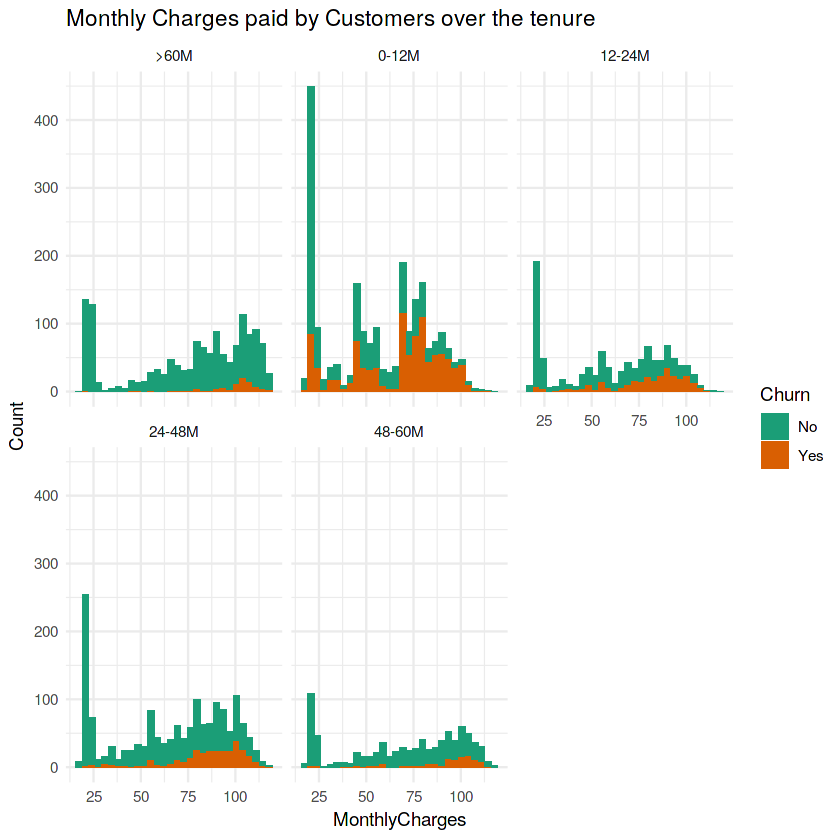

In [ ]:
churn %>% group_by(Churn) %>% 
ggplot(aes(x = MonthlyCharges, fill = Churn)) + geom_histogram() + 
facet_wrap(~tenure_group) + theme_minimal() + scale_fill_brewer(palette="Dark2") + 
ggtitle(label = "Monthly Charges paid by Customers over the tenure ") + ylab(label = "Count")

# Machine learning models

Split the data into train (80%) and test set (20%). Also, define parametrs necessary for model tuning and cross validation.
Before I jump to machine learning I would like to create a new median charge variable for people who churn vs people who do not churn. Standardize the numerical variables and remove highly correlated variables. I will **remove redundant tenure_group, Internet and TotalCharges** variables which I created during exploratory data analysis for bette visualization and **normalize MonthlyCharges and tenure variables**.

In [ ]:
# split the data
set.seed(3000)
inTrain <- createDataPartition(churn$Churn, p = 0.8, list = FALSE)

training<- churn[inTrain,]
testing<- churn[-inTrain,] 

# Create new features
training <- training %>% mutate(monthlyChargeOver64 = ifelse(MonthlyCharges > 64,"Yes","No"))
testing <- testing %>% mutate(monthlyChargeOver64 = ifelse(MonthlyCharges > 64,"Yes","No"))

training <- training %>% mutate(tenureOver15 = ifelse(tenure >= 15,"Yes","No"))
testing <- testing %>% mutate(tenureOver15 = ifelse(tenure >= 15,"Yes","No"))

# Normalize the data 
pre_process <- training %>% select_if(is.double) %>% preProcess(., method = c("center","scale"))
training <- predict(pre_process, newdata = training)
testing <- predict(pre_process, newdata = testing)

# Remove redundant variables and less important variables
training <- training %>% select(-one_of(c("tenure_group", "Internet", "TotalCharges", "gender", 
                                          "Partner","Dependents", "PhoneService", "OnlineSecurity", 
                                          "OnlineBackup", "DeviceProtection", "TechSupport")))
testing <- testing %>% select(-one_of(c("tenure_group", "Internet", "TotalCharges", "gender", 
                                        "Partner","Dependents", "PhoneService", "OnlineSecurity", 
                                        "OnlineBackup", "DeviceProtection", "TechSupport")))

# Print the dimensions of train and test set
dimensions <- data.frame(matrix(c(dim(training), dim(testing)), ncol = 2, byrow = TRUE))
colnames(dimensions) <- c("Rows", "Columns")
rownames(dimensions) <- c("Train", "Test")

print(dimensions)

train_y <- training %>% pull("Churn")
train_x <- training %>% select(-c("Churn"))

test_y <- testing %>% pull("Churn")
test_x <- testing %>% select(-c("Churn"))

# Logistic regression model

metric <- "logLoss"

ctrl <- trainControl(
  method = "cv", 
  number = 5, 
  savePredictions = "all", 
  classProbs = TRUE, 
  summaryFunction = multiClassSummary, 
  verboseIter = FALSE)

      Rows Columns
Train 5627      13
Test  1405      13


## Logistic Regression

In [ ]:
set.seed(3000)

weights <- c(1,3)
model_weights <- ifelse(train_y == "No", weights[1], weights[2])

model_glm <- train(x = train_x, y = train_y, method = "glm", trControl = ctrl, metric = metric, weights = model_weights)

# Evaluate the model on the test data
cm_glm <- cm(model = model_glm, data = test_x, target = test_y)

print(cm_glm)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  738  75
       Yes 294 298
                                          
               Accuracy : 0.7374          
                 95% CI : (0.7135, 0.7602)
    No Information Rate : 0.7345          
    P-Value [Acc > NIR] : 0.418           
                                          
                  Kappa : 0.4329          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7151          
            Specificity : 0.7989          
         Pos Pred Value : 0.9077          
         Neg Pred Value : 0.5034          
             Prevalence : 0.7345          
         Detection Rate : 0.5253          
   Detection Prevalence : 0.5786          
      Balanced Accuracy : 0.7570          
                                          
       'Positive' Class : No              
                              

In [ ]:
summary(model_glm)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4967  -1.0553  -0.4827   0.6969   4.9933  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -0.713614   0.148015  -4.821 1.43e-06 ***
SeniorCitizenYes               0.250762   0.072680   3.450 0.000560 ***
tenure                        -0.575508   0.061678  -9.331  < 2e-16 ***
MultipleLinesYes               0.478221   0.073798   6.480 9.17e-11 ***
InternetServiceFiber optic     1.959326   0.148320  13.210  < 2e-16 ***
InternetServiceNo             -1.477103   0.139983 -10.552  < 2e-16 ***
StreamingTVYes                 0.533664   0.081051   6.584 4.57e-11 ***
StreamingMoviesYes             0.579852   0.079885   7.259 3.91e-13 ***
ContractOne year              -0.735323   0.084319  -8.721  < 2e-16 ***
ContractTwo year              -1.616967   0.127654 -12.667  < 2e-16 ***
PaperlessBillingYes            0.272441   0.061493   4.430 9.40e-06

## Include Churn information in a variable

In [ ]:
# Start again
training<- churn[inTrain,]
testing<- churn[-inTrain,] 

# Create a new variable medianCharges for training and testing set separately.
medianChargesTrain <- training %>% group_by(tenure_group, Churn) %>% summarise(medianCharges = median(MonthlyCharges))
training <- left_join(training, medianChargesTrain, by = c("tenure_group","Churn"))
# Repeat for test set
medianChargesTest <- testing %>% group_by(tenure_group, Churn) %>% summarise(medianCharges = median(MonthlyCharges))
testing <- left_join(testing, medianChargesTest, by = c("tenure_group","Churn"))


# Remove redundant variables and less important variables
training <- training %>% select(-one_of(c("tenure_group", "Internet", "TotalCharges", "gender", 
                                          "Partner","Dependents", "PhoneService", "OnlineSecurity", 
                                          "OnlineBackup", "DeviceProtection", "TechSupport")))
testing <- testing %>% select(-one_of(c("tenure_group", "Internet", "TotalCharges", "gender", 
                                        "Partner","Dependents", "PhoneService", "OnlineSecurity", 
                                        "OnlineBackup", "DeviceProtection", "TechSupport")))

# Print the dimensions of train and test set
dimensions <- data.frame(matrix(c(dim(training), dim(testing)), ncol = 2, byrow = TRUE))
colnames(dimensions) <- c("Rows", "Columns")
rownames(dimensions) <- c("Train", "Test")

print(dimensions)

train_y <- training %>% pull("Churn")
train_x <- training %>% select(-c("Churn"))

test_y <- testing %>% pull("Churn")
test_x <- testing %>% select(-c("Churn"))

# Logistic regression model

metric <- "logLoss"

ctrl <- trainControl(
  method = "cv", 
  number = 5, 
  savePredictions = "all", 
  classProbs = TRUE, 
  summaryFunction = multiClassSummary, 
  verboseIter = FALSE)

      Rows Columns
Train 5627      12
Test  1405      12


## Logistic regression II

In [ ]:
set.seed(3000)

weights <- c(1,3)
model_weights <- ifelse(train_y == "No", weights[1], weights[2])

model_glm <- train(x = train_x, y = train_y, method = "glm", trControl = ctrl, metric = metric, weights = model_weights)

# Evaluate the model on the test data
cm_glm <- cm(model = model_glm, data = test_x, target = test_y)

print(cm_glm)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1032    0
       Yes    0  373
                                     
               Accuracy : 1          
                 95% CI : (0.9974, 1)
    No Information Rate : 0.7345     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.7345     
         Detection Rate : 0.7345     
   Detection Prevalence : 0.7345     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : No         
                                     
